# Análisis del problema

## Presentación
Queremos resolver el problema aplicado a una **viga de Euler**. Las condiciones a este problema son

$\Omega = [0,1]$

$u^{(4)}(x) = \frac{q(x)}{EI}$ (1)

Con las condiciones de borde $u(x)=0$ en $\partial\Omega$ y $u´´(x)=0$ en $\partial\Omega$

En este ejemplo tomaremos una viga de 20cm x 30cm, q(x) va a ser la carga sobre la barra y esta la vamos a diseccionar en 3. Entonces $q= (q_1,q_2,q_3)$ donde $q_i$ representa la carga en el tercio i y este sera el parámetro. También $E$ e $I$ son asociadas a las condiciones de la viga que asumimos constante.

## Formulación débil

Queremos obtener la formulación debil de la ecuación (1). Para eso multiplicamos por la función v que vale 0 en donde u esya definida. Osea v(x)=0 en $\partial\Omega$. Luego integro en $\Omega$ y obtengo:

$\int_{\Omega}u^{(4)}v dx = \int_\Omega \frac{q(x)}{EI} v dx$

Ahora el objetivo es bajar el orden de las derivadas al máximo posible de u y v. Por lo tanto aplico partes en el término izquierdo de la igualdad.

$\int_{\Omega}u^{(4)}v dx = -\int_{\Omega}u^{(3)}v´dx + \int_{\partial\Omega}u^{(3)}v dx$

Vemos que la última integral vale 0 por la definición de v. Asi que queda

$\int_{\Omega}u^{(4)}v dx = -\int_{\Omega}u^{(3)}v´dx $

Al término de la derecha le aplicamos partes devuelta y obtenemos:

 $-\int_{\Omega}u^{(3)}v´dx = \int_{\Omega}u^{(2)}v^{(2)}dx - \int_{\partial\Omega}u^{(2)}v´dx$

 Este último término vale 0 por condiciónes de borde de u. Quedando

 $\int_{\Omega}u^{(4)}v dx = \int_{\Omega}u^{(2)}v^{(2)}dx$

 Por lo tanto la formulación débil del problema (1) es:

 $\int_{\Omega}u^{(2)}v^{(2)}dx = \int_\Omega \frac{q(x)}{EI} v dx$

 En donde llamamos $a(u,v;\mu) = \int_{\Omega}u^{(2)}v^{(2)}dx $ y $f(v;\mu) = \int_\Omega \frac{q(x)}{EI} v dx$

In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh";
    from dolfin import *

--2025-04-30 14:52:19--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-04-30 14:52:19 (41.9 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/d7ddd552/releases/pybi

In [2]:
# Install RBniCS
try:
    import rbnics
except ImportError:
    !pip3 install git+https://github.com/RBniCS/RBniCS.git
    import rbnics
import rbnics.utils.config
assert "dolfin" in rbnics.utils.config.config.get("backends", "required backends")
from rbnics import *

  Cloning https://github.com/RBniCS/RBniCS.git to /tmp/pip-req-build-k3khrybx
  Running command git clone --filter=blob:none --quiet https://github.com/RBniCS/RBniCS.git /tmp/pip-req-build-k3khrybx
  Resolved https://github.com/RBniCS/RBniCS.git to commit b23d20d68d22579c0995b16025f7f1e858d65259
  Preparing metadata (setup.py) ... done
  Created wheel for RBniCS: filename=RBniCS-0.2.0-py3-none-any.whl size=598339 sha256=d5cefd1582dab1d1763ab9ff02c748e02acbe379114df9b93ebd67c03f548ce5
  Stored in directory: /tmp/pip-ephem-wheel-cache-x9j1prr4/wheels/91/6e/53/8e8074380bbeb5ca55786b492fcb71afa192955accca0a7cea
Successfully built RBniCS


In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class BeamProblem(EllipticCoerciveProblem):

    # Inicialización
    def __init__(self, V, **kwargs):
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # Datos de FEniCS
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.E = 2.1e6  # Módulo de elasticidad (t/m^2, ejemplo concreto)
        self.I = 45000 / 10000  # Momento de inercia (m^4)

    # Nombre del problema
    def name(self):
        return "BeamProblem"

    # Términos theta para la expansión afín
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = self.E * self.I  # Solo un término para la rigidez
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0]  # q1
            theta_f1 = mu[1]  # q2
            theta_f2 = mu[2]  # q3
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Ensamblaje de operadores
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(grad(u)), grad(grad(v))) * dx  # Forma bilineal: u'' v''
            return (a0,)
        elif term == "f":
            # Definir carga por tramos
            f0 = v * dx(1) # Primer tercio
            f1 = v * dx(2) # Segundo tercio
            f2 = v * dx(3) # Tercer tercio
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2)]  # u(1) = 0
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [ ]:
# Crear malla y subdominios
mesh = IntervalMesh(100, 0, 1)  # Malla en [0,1]
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)

# Marcar subdominios (tercios)
subdomains.set_all(0)
for cell in cells(mesh):
    x = cell.midpoint().x()
    if x <= 1/3:
        subdomains[cell] = 1
    elif x <= 2/3:
        subdomains[cell] = 2
    else:
        subdomains[cell] = 3

# Marcar fronteras
boundaries.set_all(0)
for facet in facets(mesh):
    x = facet.midpoint().x()
    if near(x, 0):
        boundaries[facet] = 1  # x = 0
    elif near(x, 1):
        boundaries[facet] = 2  # x = 1

# Espacio funcional
V = FunctionSpace(mesh, "Lagrange", 4)  # Grado 2 para H^2

In [ ]:
# Crear problema
problem = BeamProblem(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0)]  # Rango de q1, q2, q3
problem.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10)  # Máximo de funciones en la base
reduction_method.set_tolerance(0.000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method.initialize_training_set(50)
reduced_problem = reduction_method.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9b3c54fb60591e96b5d559708ef15ace66900177

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG4(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG4(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.130202 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e8583c329588bec481bf4e3496ce5d24b12badeb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG4(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG4(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0130999 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------

=           BeamProblem POD-Galerkin offline phase begins            =

################################# 0 ##################################
truth solve for mu = (-9.899012426914357, -5.0771208229810245, 3.968514044172853)
update snapshots matrix

################################# 1 ##################################
truth solve for mu = (-3.2529286118843004, -0.92148462818772, 3.841519878777362)
update snapshots matrix

################################# 2 ##################################
truth solve for mu = (9.392142961911546, 7.267747457606504, 7.831807684738582)
update snapshots matrix

################################# 3 ##################################
truth solve for mu = (6.539129429040539, -0.6965863372510093, 9.345184348467363)
update snapshots matrix

################################# 4 ##################################
truth solve for mu = (8.467784076657413, 6.389920743581115, 6.520739778933898)
update snapshots matrix

################################# 5 ##########

ValueError: array must not contain infs or NaNs

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (5.0, 5.0, 5.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()

# Visualización
plot(reduced_solution, reduced_problem=reduced_problem)
plt.show()

LinAlgError: Singular matrix

# Otras alternativas

Vemos que el código anterior no funciona bien. La razó de esto es que no se puede especificar que $u"(x)$ valga 0 en los bordes. Esto es porque la interpolación a trozos de Lagrange no garantiza que la derivada primera sea continua en los bordes.

Para esto vamos a usar un cambio de variable $w=u"$ de esta forma nos podemos asegurar con condiciones de Dirichlet que $u"$ valga 0 en el borde. Por lo tanto tenemos este sistema

$
\left\{
\begin{align}
w &= u'' \\
EI w'' &= q
\end{align}
\right.
$

Con condiciones de borde $u(0)=u(1)=w(0)=w(1)=0$

Por lo tanto aplico la formualción débil a ambas ecuaciones quedandome
$
\left\{
\begin{align}
\int_\Omega wv_1 + \int_\Omega u´v_1´&= 0 \\
-EI \int_\Omega w'v_2´ &= \int_\Omega qv_2
\end{align}
\right.
$

Si sumamos ambas ecuaciones obtenemos:

$ \int_\Omega wv_1 + \int_\Omega u´v_1´-EI \int_\Omega w'v_2´ = \int_\Omega qv_2 $

Notar que ahora precisamos 2 espacios de funciones, uno para $v_1$ y otro para $v_2$

In [4]:
class BeamProblem2(EllipticCoerciveProblem):

    # Inicialización
    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        # Datos de FEniCS
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u, self.w = TrialFunction(M)
        self.v1, self.v2 = TestFunction(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.E = 3e10  # Módulo de elasticidad (t/m^2, ejemplo concreto)
        self.I = 0.00045  # Momento de inercia (m^4)
        self.M = M

    # Nombre del problema
    def name(self):
        return "BeamProblem"

    # Términos theta para la expansión afín
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1  # Solo un término para la rigidez
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0]*10**4 # q1
            theta_f1 = mu[1]*10**4  # q2
            theta_f2 = mu[2]*10**4  # q3
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Ensamblaje de operadores
    def assemble_operator(self, term):
        v1 = self.v1
        v2 = self.v2
        dx = self.dx
        if term == "a":
            u = self.u
            w=self.w
            EI = self.E * self.I
            a0 = w * v1 * dx + inner(grad(u), grad(v1)) * dx - EI * inner(grad(w), grad(v2)) * dx
            return (a0,)
        elif term == "f":
            # Definir carga por tramos
            f0 = v2 * dx(1) # Primer tercio
            f1 = v2 * dx(2) # Segundo tercio
            f2 = v2 * dx(3) # Tercer tercio
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 2),  # u(1) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 1),  # w(0) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 2)]  # w(1) = 0
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            w = self.w
            x0 = inner(u, v1) * dx + inner(grad(u), grad(v1)) * dx + inner(w, v2) * dx + inner(grad(w), grad(v2)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [5]:
# Crear malla y subdominios
tamaño_barra= 10
mesh = IntervalMesh(24, 0, tamaño_barra)
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)

# Marcar subdominios (tercios)
subdomains.set_all(0)
for cell in cells(mesh):
    x = cell.midpoint().x()
    if x <= tamaño_barra/3:
        subdomains[cell] = 1
    elif x <= 2*tamaño_barra/3:
        subdomains[cell] = 2
    else:
        subdomains[cell] = 3

# Marcar fronteras
boundaries.set_all(0)
for facet in facets(mesh):
    x = facet.midpoint().x()
    if near(x, 0):
        boundaries[facet] = 1  # x = 0
    elif near(x, tamaño_barra):
        boundaries[facet] = 2  # x = 1

# Definir elementos finitos y espacio mixto
V = FiniteElement("P", mesh.ufl_cell(), 3)  # Subimos a grado 3 para mayor estabilidad
W = FiniteElement("P", mesh.ufl_cell(), 3)  # Igual para w
M = FunctionSpace(mesh, MixedElement([V, W]))  # Espacio mixto

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_406e980b9c40d0c770ee9d26b4b57440d97df7ac

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00271702 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0387008 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ffa76cc7b0256d138f49ed56fe0dadbd91d3f4c3

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00216484 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0117159 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [6]:
# Crear problema
problem = BeamProblem2(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0)]  # Rango de q1, q2, q3
problem.set_mu_range(mu_range)

In [7]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10)  # Máximo de funciones en la base
reduction_method.set_tolerance(0.000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method.initialize_training_set(50)
reduced_problem = reduction_method.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_afe130acd5f89a246ace747e9c2d489f6a14530c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.113408 seconds.

INFO:FFC:Compiler st

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b54120a77687b423ec55c3f9ef09ce0cf6b53d22

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00510812 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0292654 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0e960018c13794ab01478d279066e99280225e3b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00378227 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.015137 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b4e93b9b5ea51133f35fab55699c031eac6b82b8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00764394 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0293953 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_7e4cba8ae9bbc7db9b63f8672ebdeba5dd07f145

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0095613 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0328774 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_7fb7b6c400f1f421c69d1a80e8c853d7068a30d1

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00252819 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00797009 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0b6efd2eb33a16af311487bf4b9256c2b70887a8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0208676 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2d619497b2a7ff1f25c5ea77f2f5035c3b85c73a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0229414 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_157bd9fff057bab5ea4e75dc4bcc0d4376fe0d03

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0169978 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cf6f6cc039b40fede1f0f2fa55009010053a4a9d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0243127 seconds.

INFO:FFC:Compiler s

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5342a3e6876f57a272533e2398f7ce797bcb4a8a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG3(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0159266 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2366221f5926b78f9338d0a839f38da437a9ff5e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_40]'
  Unique elements:           'CG3(?,?), R0(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), R0(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0165036 seconds.

INFO:FFC:Compile

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_24cc9ceff403cbc570d28f2d22fa6fb070950306

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0016582 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0091157 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

=                BeamProblem POD-Galerkin offline phase begins                 =

###################################### 0 #######################################
truth solve for mu = (-3.4129320071264635, 2.3566659864418824, -2.4973892998950653)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (9.445369885765626, 9.649385222395242, -9.091017153953118)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (9.348711528771247, -3.505829103974256, -1.2455565568762044)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (8.029156239919029, -6.8621777038931615, -7.373940682064251)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (5.449453846634679, 1.5241298556058034, -5.374217390606775)
upda

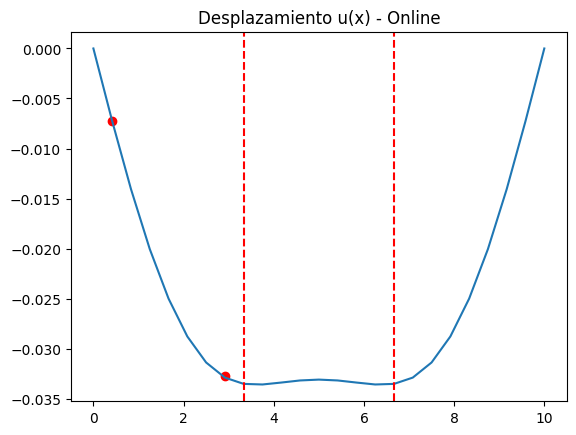

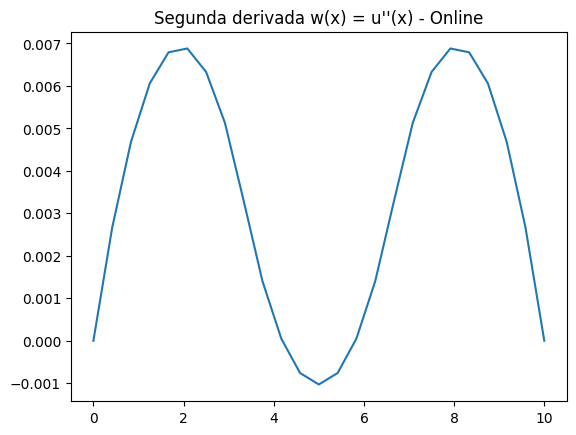

In [9]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (-5, 4.2, -5)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()

# Reconstruir la solución en el espacio completo
full_solution = reduced_problem.basis_functions * reduced_solution  # Producto matricial con las bases
u, w = full_solution.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(u, title="Desplazamiento u(x) - Online")
#Recta vertical
plt.axvline(x=tamaño_barra/3, color='r', linestyle='--')
plt.axvline(x=2*tamaño_barra/3, color='r', linestyle='--')
#Agregar un punto
plt.scatter(0.42, -7224e-6, color='r')
plt.scatter(2.91,-32770e-6, color='r')
plt.show()
plt.figure()
plot(w, title="Segunda derivada w(x) = u''(x) - Online")
plt.show()

## Ahora con fuerzas en ambos sentidos

Ahora el campo u es una función $u:\mathbb{R} → \mathbb{R}^2$ o sea que $u(x)= (u_1(x),u_2(x))$ en donde
$u_1$ es la componente longitudinal y $u_2$ la transversal.

Por lo que ahora tendríamos que resolver el siguiente problema
$
\left\{
\begin{align}
u_1´ &= \frac{q_1}{EA} \\
w &= u_2'' \\
EI w'' &= q_2
\end{align}
\right.
$

Notar también que las cargas $q$ serán oblicuas y las descomponemos en $q(x)=(q_1(x),q_2(x))$ en donde $q_1$ es la carga longitudinal y $q_2$ la transversal

Luego obteniendi la formulación débil tendríamos

Por lo tanto aplico la formualción débil a ambas ecuaciones quedandome
$
\left\{
\begin{align}
\int_\Omega u_1´v_1 &= \int_\Omega \frac{q_1}{EA}v_1\\
\int_\Omega wv_2 + \int_\Omega u_2´v_2´&= 0 \\
-EI \int_\Omega w'v_3´ &= \int_\Omega qv_3
\end{align}
\right.
$

Si sumamos ambas ecuaciones obtenemos:

$ \int_\Omega wv_2 + \int_\Omega u_2´v_2´-EI \int_\Omega w'v_3´ + \int_\Omega u_1´v_1= \int_\Omega qv_2  + \int_\Omega \frac{q_1}{EA}v_1 $

Con condiciones de borde $u_1(0)=0$, $u_2(0)=u_2(1)=0$ y $w(0)=w(1)=0$


Ahora para dividir la barra en tercios y hacer 3 fuerzas oblicuas distintas en cada tercio esto lo podríamos ver entonces como 6 fuerzas distintas 3 longitudinales y 3 transversales. Por lo tanto el parametro tendría el siguiente formato
$ \mu = (q_1^l,q_1^t,q_2^l,q_2^t,q_3^l,q_3^t)$ en donde el subindice hace referecia al tercio al que esta modificando y el superindice al tipo de fuerza (l longitudinal y t transversal)

Por lo tanto el lado derecho quedarían estas integraes
$\sum_{i=0}^{2} \frac{\mu[2i]}{EA}\int_{\Omega_i} v_1 dx_i + \frac{\mu[2i+1]}{EI}\int_{\Omega_i} v_3 dx_i$

In [ ]:
class BeamProblem2D(EllipticCoerciveProblem):

    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u1, self.u2, self.w = TrialFunction(M)
        self.v1, self.v2, self.v3 = TestFunction(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        self.E = 3e10
        self.I = 0.00045
        self.A = 0.02 * 0.03
        self.M = M

    def name(self):
        return "BeamProblem"

    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0] * 1e4 / self.E  # q_1^0 / A
            theta_f1 = mu[1] * 1e4 / self.E  # q_2^0 / I
            theta_f2 = mu[2] * 1e4 / self.E  # q_1^1 / A
            theta_f3 = mu[3] * 1e4 / self.E  # q_2^1 / I
            theta_f4 = mu[4] * 1e4 / self.E  # q_1^2 / A
            theta_f5 = mu[5] * 1e4 / self.E  # q_2^2 / I
            return (theta_f0, theta_f1, theta_f2, theta_f3, theta_f4, theta_f5)
        else:
            raise ValueError("Invalid term for compute_theta().")

    def assemble_operator(self, term):
        v1 = self.v1
        v2 = self.v2
        v3 = self.v3
        dx = self.dx
        if term == "a":
            u1 = self.u1
            u2 = self.u2
            w = self.w
            EI = self.E * self.I
            a0 = w * v2 * dx + inner(grad(u2), grad(v2)) * dx - inner(grad(w), grad(v3)) * dx + u1.dx(0) * v1 * dx
            return (a0,)
        elif term == "f":
            f0 = v1 * dx(1) / self.A
            f1 = v3 * dx(1) / self.I
            f2 = v1 * dx(2) / self.A
            f3 = v3 * dx(2) / self.I
            f4 = v1 * dx(3) / self.A
            f5 = v3 * dx(3) / self.I
            return (f0, f1, f2, f3, f4, f5)
        elif term == "dirichlet_bc":
            bc0 = [ DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.M.sub(2), Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.M.sub(2), Constant(0.0), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product":
            u1 = self.u1
            u2 = self.u2
            w = self.w
            x0 = inner(u2, v2) * dx + inner(grad(u2), grad(v2)) * dx + \
                 inner(w, v3) * dx + inner(grad(w), grad(v3)) * dx + \
                 inner(u1, v1) * dx + inner(grad(u1), grad(v1)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [ ]:
# Crear malla y subdominios
tamaño_barra = 10
mesh = IntervalMesh(24, 0, tamaño_barra)
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)

# Marcar subdominios (tercios)
subdomains.set_all(0)
for cell in cells(mesh):
    x = cell.midpoint().x()
    if x <= tamaño_barra/3:
        subdomains[cell] = 1
    elif x <= 2*tamaño_barra/3:
        subdomains[cell] = 2
    else:
        subdomains[cell] = 3

# Marcar fronteras
boundaries.set_all(0)
for facet in facets(mesh):
    x = facet.midpoint().x()
    if near(x, 0):
        boundaries[facet] = 1
    elif near(x, tamaño_barra):
        boundaries[facet] = 2

# Definir elementos finitos y espacio mixto
V1 = FiniteElement("P", mesh.ufl_cell(), 3)
V2 = FiniteElement("P", mesh.ufl_cell(), 3)
W = FiniteElement("P", mesh.ufl_cell(), 3)
M = FunctionSpace(mesh, MixedElement([V1, V2, W]))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_fa3a4f1c6e8b5d25f07c535aae26952dea13d29c

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00251484 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0628026 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ffa76cc7b0256d138f49ed56fe0dadbd91d3f4c3

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00183725 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00806904 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

In [ ]:
# Crear problema
problem2D = BeamProblem2D(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10.0, 10.0) for _ in range(6)]
problem2D.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method = PODGalerkin(problem2D)
reduction_method.set_Nmax(10)
reduction_method.set_tolerance(0.000001)
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f4c5f89cfd7bacc71e85b181f0457f8cb3e7851a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,
                             ?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,
                             ?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 f

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b54120a77687b423ec55c3f9ef09ce0cf6b53d22

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00239992 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.011616 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0e960018c13794ab01478d279066e99280225e3b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00260091 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0106282 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b4e93b9b5ea51133f35fab55699c031eac6b82b8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00217986 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0123045 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_9c148c4c560d3724f35d1a4bc5015f7eb7ed6400

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00232363 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0116518 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_7fb7b6c400f1f421c69d1a80e8c853d7068a30d1

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00483012 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00846434 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_340fa19d3035eea26690d2c61f30e659aa2e6cd7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_15]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_24cc9ceff403cbc570d28f2d22fa6fb070950306

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00207186 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00683212 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a6653bce61e45608e331e70b88fcf152a0371369

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_16]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e1d15fc84bee1ec88763debe0983b09932832648

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_17]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6b58abf5fd52188451fbd889e91984b8cc9f59fd

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_18]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9abd8efe6969496d623037862d86b5da2c57af73

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_19]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_46f4b0462f022428a4db57e4c0d8bfce9e382807

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_20]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, R0(?,?), Vector<1
                              x CG1(?,?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7bba1dd9d979d8a65fb4579dc8f1068ae430a3b2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,
                             ?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,
                             ?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 f

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5342a3e6876f57a272533e2398f7ce797bcb4a8a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG3(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.143957 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2366221f5926b78f9338d0a839f38da437a9ff5e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_55]'
  Unique elements:           'CG3(?,?), R0(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), R0(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0520041 seconds.

INFO:FFC:Compile

=                BeamProblem POD-Galerkin offline phase begins                 =

###################################### 0 #######################################
truth solve for mu = (8.016794347285078, 2.1504505841862525, -7.145281780824105, -8.981992796377238, -4.802734285879325, 3.2307485293129403)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (6.718698468038134, 0.1710875434584498, 2.7632507075359065, 2.3772030837844866, -8.603624446664242, -7.909699709376028)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (8.133518875932651, -8.285876933380054, -7.7676119431354, 2.375266133381027, -3.4363929002377613, 1.2117759504085228)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (7.205967859779847, -7.29517491615244, 4.367391141625358, 5.432821888905234, 

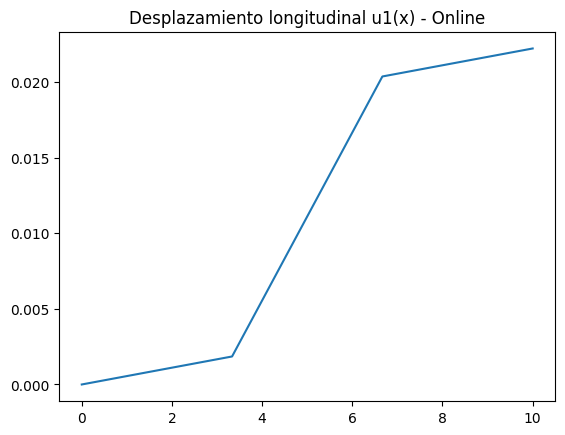

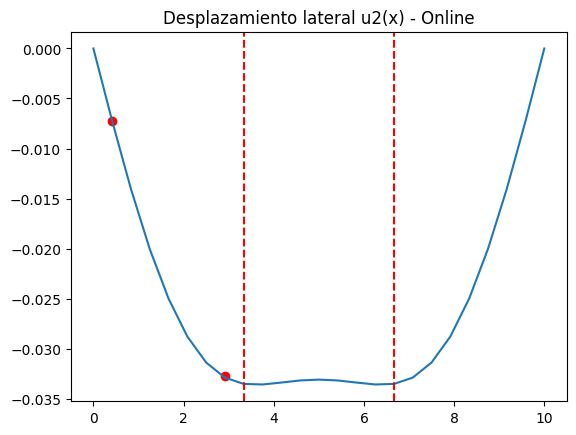

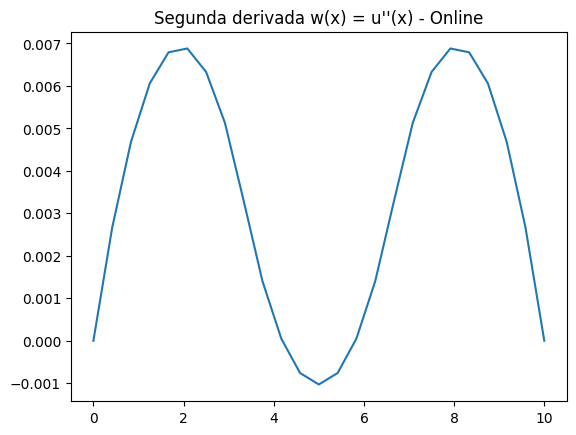

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (1, -5, 10, 4.2, 1, -5)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()

# Reconstruir la solución en el espacio completo
full_solution = reduced_problem.basis_functions * reduced_solution  # Producto matricial con las bases
u1, u2, w = full_solution.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(u1, title="Desplazamiento longitudinal u1(x) - Online")
plt.show()
plt.figure()
plot(u2, title="Desplazamiento lateral u2(x) - Online")
#Recta vertical
plt.axvline(x=tamaño_barra/3, color='r', linestyle='--')
plt.axvline(x=2*tamaño_barra/3, color='r', linestyle='--')
#Agregar un punto
plt.scatter(0.42, -7224e-6, color='r')
plt.scatter(2.91,-32770e-6, color='r')
plt.show()
plt.figure()
plot(w, title="Segunda derivada w(x) = u''(x) - Online")
plt.show()

# Barras con distinta área

Ahora veremos que pasa cuando a una barra dividida en 3 secciones además de variar las cargas en ellas variamos el área de la barra. Esto afectaría a $I=\frac{bh^3}{12}$. Y la condición en las fronteras de los subdominios sería $u_1"·I_1 = u_2"·I_2$. Dejamos la base fija y la altura variable. Luego $I=Bh^3$ en donde $B=0.20/12$

## Opción 1

Podemos ver que $u"$ no es continua pero $EIu"$ sí lo es. Entonces podríamos tomar $w=EIu"$ ya que esto haría que $w$ sea continuo. La formulación débil queda igual salvo por el cambio de lugar en el $EI$.

Por alguna razón esto no funciona

In [ ]:
class BeamProblem_h(EllipticCoerciveProblem):

    # Inicialización
    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        # Datos de FEniCS
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u, self.w = TrialFunction(M)
        self.v1, self.v2 = TestFunction(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.E = 3e10  # Módulo de elasticidad (t/m^2, ejemplo concreto)
        self.b = 0.2/12
        self.M = M

    # Nombre del problema
    def name(self):
        return "BeamProblem_variando_altura"

    # Términos theta para la expansión afín
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1  # Solo un término para la rigidez
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0]*10**4
            theta_f1 = mu[1]*10**4
            theta_f2 = mu[2]*10**4
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Ensamblaje de operadores
    def assemble_operator(self, term):
        v1 = self.v1
        v2 = self.v2
        dx = self.dx
        mu = self.mu

        # Crear una función para I en todo el dominio
        I_func = Function(FunctionSpace(self.M.mesh(), "DG", 0))
        I_values = I_func.vector().get_local()
        cell_domains = self.subdomains.array()

        # Llenar los valores de I según el subdominio
        for i in range(len(I_values)):
            if cell_domains[i] == 1:
                I_values[i] = self.b * mu[3] ** 3
            elif cell_domains[i] == 2:
                I_values[i] = self.b * mu[4] ** 3
            elif cell_domains[i] == 3:
                I_values[i] = self.b * mu[5] ** 3
        I_func.vector().set_local(I_values)
        I_func.vector().apply("insert")

        if term == "a":
            u = self.u
            w = self.w
            EI = self.E * I_func
            a0 = w * v1 * dx + EI * inner(grad(u), grad(v1)) * dx - inner(grad(w), grad(v2)) * dx
            return (a0,)
        elif term == "f":
            # Definir carga por tramos
            f0 = v2 * dx(1) # Primer tercio
            f1 = v2 * dx(2) # Segundo tercio
            f2 = v2 * dx(3) # Tercer tercio
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 2),  # u(1) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 1),  # w(0) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 2)]  # w(1) = 0
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            w = self.w
            x0 = inner(u, v1) * dx + inner(grad(u), grad(v1)) * dx + inner(w, v2) * dx + inner(grad(w), grad(v2)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [ ]:
# Crear malla y subdominios
tamaño_barra= 10
mesh = IntervalMesh(50, 0, tamaño_barra)
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)

# Marcar subdominios (tercios)
subdomains.set_all(0)
for cell in cells(mesh):
    x = cell.midpoint().x()
    if x <= tamaño_barra/3:
        subdomains[cell] = 1
    elif x <= 2*tamaño_barra/3:
        subdomains[cell] = 2
    else:
        subdomains[cell] = 3

# Marcar fronteras
boundaries.set_all(0)
for facet in facets(mesh):
    x = facet.midpoint().x()
    if near(x, 0):
        boundaries[facet] = 1  # x = 0
    elif near(x, tamaño_barra):
        boundaries[facet] = 2  # x = 1

# Definir elementos finitos y espacio mixto
V = FiniteElement("P", mesh.ufl_cell(), 3)  # Subimos a grado 3 para mayor estabilidad
W = FiniteElement("P", mesh.ufl_cell(), 3)  # Igual para w
M = FunctionSpace(mesh, MixedElement([V, W]))  # Espacio mixto

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_406e980b9c40d0c770ee9d26b4b57440d97df7ac

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0106308 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.10835 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ffa76cc7b0256d138f49ed56fe0dadbd91d3f4c3

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00678682 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0282063 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [ ]:
# Crear problema
problem_h = BeamProblem_h(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0), (0.01, 1), (0.01, 1), (0.01, 1)]
problem_h.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method_h = PODGalerkin(problem_h)
reduction_method_h.set_Nmax(10)  # Máximo de funciones en la base
reduction_method_h.set_tolerance(0.000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method_h.initialize_training_set(100)
reduced_problem_h = reduction_method_h.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4c90278d86d1a719b3f0db70734bc959f8a09d71

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00237656 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0191669 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cab1c28cbf6e639f176cce2eae7de0ea405e78fc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_14]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, DG0(?,?), Vector<1 x CG1(?,
                             ?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, DG0(?,?), Vector<1 x CG1(?,
                             ?)>, CG3(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b54120a77687b423ec55c3f9ef09ce0cf6b53d22

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00577044 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0253999 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0e960018c13794ab01478d279066e99280225e3b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00297999 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.010206 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b4e93b9b5ea51133f35fab55699c031eac6b82b8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00281 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0112052 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_7e4cba8ae9bbc7db9b63f8672ebdeba5dd07f145

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00193477 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0167317 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_849cd8a246fc515e3e56416c600a4b14163c1040

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00276399 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.013211 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_7fb7b6c400f1f421c69d1a80e8c853d7068a30d1

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0032661 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00695014 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0b6efd2eb33a16af311487bf4b9256c2b70887a8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0307677 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2d619497b2a7ff1f25c5ea77f2f5035c3b85c73a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0178692 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_157bd9fff057bab5ea4e75dc4bcc0d4376fe0d03

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0230982 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cf6f6cc039b40fede1f0f2fa55009010053a4a9d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG3(?,?), CG3(?,?)>, Vector<1 x CG1(?,?)>, CG3(?
                             ,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0257609 seconds.

INFO:FFC:Compiler s

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5342a3e6876f57a272533e2398f7ce797bcb4a8a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG3(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 6
INFO:FFC:  quadrature_degree: 6
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0166962 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2366221f5926b78f9338d0a839f38da437a9ff5e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_75]'
  Unique elements:           'CG3(?,?), R0(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG3(?,?), R0(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0258896 seconds.

INFO:FFC:Compile

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_24cc9ceff403cbc570d28f2d22fa6fb070950306

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0015471 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00700307 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

=        BeamProblem_variando_altura POD-Galerkin offline phase begins         =

###################################### 0 #######################################
truth solve for mu = (2.846894011306304, -3.2958469490660676, -7.085350868499358, 0.4930965822853118, 0.7361427427007533, 0.627176635455972)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (-1.1782346898980212, -9.10674511371083, -2.006839802657476, 0.02511635870077575, 0.9157339702081321, 0.4463888365802588)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (-4.373727840537911, 2.6794559138864322, 8.52291987683843, 0.9230854743517052, 0.16822222757318664, 0.9990845382776724)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (2.280956843126951, -0.016736327631516446, -9.894317471275922, 0.37307824

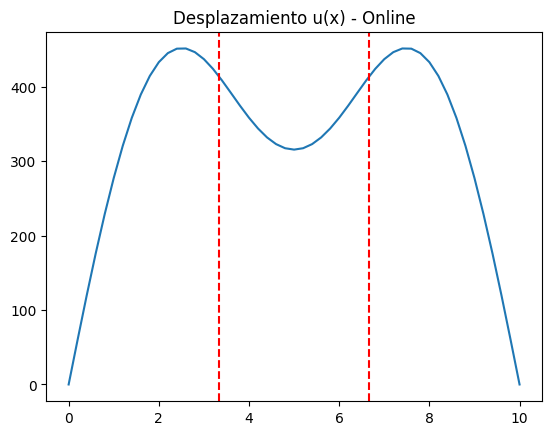

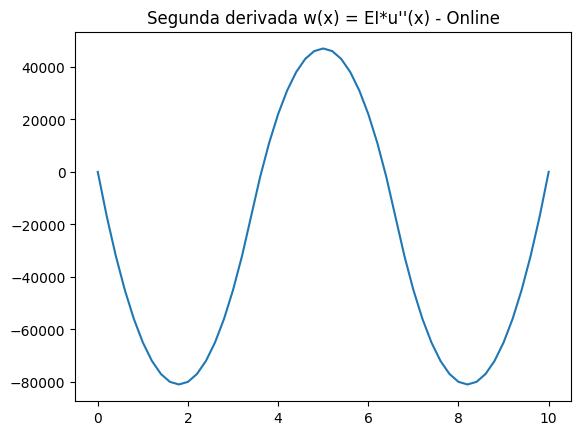

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (5, -5, 5, 1, 0.1, 0.1)
reduced_problem_h.set_mu(online_mu)
reduced_solution_h = reduced_problem_h.solve()

# Reconstruir la solución en el espacio completo
full_solution = reduced_problem_h.basis_functions * reduced_solution_h  # Producto matricial con las bases
u, w = full_solution.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(u, title="Desplazamiento u(x) - Online")
#Recta vertical
plt.axvline(x=tamaño_barra/3, color='r', linestyle='--')
plt.axvline(x=2*tamaño_barra/3, color='r', linestyle='--')
plt.show()
plt.figure()
plot(w, title="Segunda derivada w(x) = EI*u''(x) - Online")
plt.show()

In [ ]:
I = Expression(
    "x[0] <= L/3 ? b * pow(mu3, 3)  : (x[0] <= 2*L/3 ? b * pow(mu4, 3) : b * pow(mu5, 3))",
    L=tamaño_barra, b=0.2/12, mu3=1, mu4=2, mu5=3, degree=0
)

print(I(1)*12/0.2)
print(I(5)*12/0.2)
print(I(9)*12/0.2)


1.0
8.0
27.0


## Opción 2

Crear un $w_i$ para cada subdominio.

Problemas:

1. Cuando hago partes en las regiones hay términos que no se anulan. EJEMPLO

$\int_{R_1} w_1"v_1 = EI_1 \int_{R_1} qv_1$. Haciendo partes en el primer término

$\int_{R_1} w_1"v_1 = -w_1´v_1|0 + w_1´v_1|1/3 - \int_{R_1} w_1´v_1´$

Sabemos que como $v_1(0)=0$ el primer término se anula. Pero el segundo no, entonces que pasa con $w_1´v_1|1/3$?

Al sumar los términos para todas las regiones nos quedaría esta parte como:

$w_1´v_1|1/3 - w_2´v_2|1/3 + w_2´v_2|2/3 - w_3´v_3|2/3$. Que pasaría con esto? Se anula?

2. Aumentaría mucho la cantidad de nodos, podríamos tener la curta parte y ahí laq optimización no se si es tan útil

3. Como hago para que se cumpla la condición $w_1·I_1 = w_2·I_2$?

In [ ]:
from dolfin import *
from rbnics import *

class BeamProblem_w(EllipticCoerciveProblem):
    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        # Espacio mixto: u, w1, w2, w3
        self.u, self.w1, self.w2, self.w3 = TrialFunctions(M)
        self.v, self.v1, self.v2, self.v3 = TestFunctions(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.E = 3e10  # Módulo de elasticidad (t/m^2)
        self.b = 0.2   # Ancho de la viga
        self.L = tamaño_barra
        self.M = M

    def name(self):
        return "BeamProblem_w"

    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1  # Rigidez
            theta_a1 = 0.2*mu[3]**3 / 12  # I1 = b h1^3 / 12
            theta_a2 = 0.2*mu[4]**3 / 12  # I2 = b h2^3 / 12
            theta_a3 = 0.2*mu[5]**3 / 12  # I3 = b h3^3 / 12
            theta_a4 = 1
            theta_a5 = 1
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5)
        elif term == "f":
            theta_f0 = mu[0] * 10**4  # q1
            theta_f1 = mu[1] * 10**4  # q2
            theta_f2 = mu[2] * 10**4  # q3
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    def assemble_operator(self, term):
        v, v1, v2, v3 = self.v, self.v1, self.v2, self.v3
        dx = self.dx
        mu = self.mu
        if term == "a":
            u, w1, w2, w3 = self.u, self.w1, self.w2, self.w3
            # Término de rigidez: w_i = u'' en cada subdominio
            a0 = inner(grad(u), grad(v)) * dx + inner(w1, v) * dx(1) + inner(w2, v) * dx(2) + inner(w3, v) * dx(3)
            # Término de equilibrio: (E I_i w_i)'' = q_i
            a1 = -self.E * inner(grad(w1), grad(v1)) * dx(1)
            a2 = -self.E * inner(grad(w2), grad(v2)) * dx(2)
            a3 = -self.E * inner(grad(w3), grad(v3)) * dx(3)
            # Condiciones de continuidad del momento (penalización débil)
            penalty = 1e10  # Parámetro de penalización
            x1 = self.L / 3
            x2 = 2 * self.L / 3
            delta1 = DiracDelta(x1, degree=0)
            delta2 = DiracDelta(x2, degree=0)
            a4 = penalty * (self.E * mu[3] * w1 - self.E * mu[4] * w2)**2 * delta1 * dx
            a5 = penalty * (self.E * mu[4] * w2 - self.E * mu[5] * w3)**2 * delta1 * dx
            return (a0, a1, a2, a3, a4, a5)
        elif term == "f":
            f0 = v1 * dx(1)  # Carga en subdominio 1
            f1 = v2 * dx(2)  # Carga en subdominio 2
            f2 = v3 * dx(3)  # Carga en subdominio 3
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 2)]  # u(L) = 0
            return (bc0,)
        elif term == "inner_product":
            u, w1, w2, w3 = self.u, self.w1, self.w2, self.w3
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx +inner(w1, v1) * dx(1) + inner(grad(w1), grad(v1)) * dx(1)+inner(w2, v2) * dx(2) + inner(grad(w2), grad(v2)) * dx(2)+inner(w3, v3) * dx(3) + inner(grad(w3), grad(v3)) * dx(3)
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

# Definir DiracDelta (aproximación)
class DiracDelta(UserExpression):
    def __init__(self, x0, **kwargs):
        self.x0 = x0
        super().__init__(**kwargs)
    def eval(self, value, x):
        eps = 1e-5  # Ancho de la aproximación
        if abs(x[0] - self.x0) < eps:
            value[0] = 1.0 / (2 * eps)
        else:
            value[0] = 0.0

In [ ]:
tamaño_barra = 10
mesh = IntervalMesh(50, 0, tamaño_barra)
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
subdomains.set_all(0)
for cell in cells(mesh):
    x = cell.midpoint().x()
    if x <= tamaño_barra/3:
        subdomains[cell] = 1
    elif x <= 2*tamaño_barra/3:
        subdomains[cell] = 2
    else:
        subdomains[cell] = 3
boundaries.set_all(0)
for facet in facets(mesh):
    x = facet.midpoint().x()
    if near(x, 0):
        boundaries[facet] = 1
    elif near(x, tamaño_barra):
        boundaries[facet] = 2

V = FiniteElement("P", mesh.ufl_cell(), 3)  # u: deflexión
W = FiniteElement("P", mesh.ufl_cell(), 1)  # w_i: curvatura
M = FunctionSpace(mesh, MixedElement([V, W, W, W]))  # u, w1, w2, w3

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_589a189b35f50a8e69ca3fdabb3d6b0617c8419d

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00385261 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0660419 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ffa76cc7b0256d138f49ed56fe0dadbd91d3f4c3

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00228477 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0103824 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0aceea476c4466c38bcd4b3da92b7c720101a8ac

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00356603 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0162497 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [ ]:
problem_w = BeamProblem_w(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0), (0.01, 1), (0.01, 1), (0.01, 1)]
problem_w.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method_w = PODGalerkin(problem_w)
reduction_method_w.set_Nmax(10)  # Máximo de funciones en la base
reduction_method_w.set_tolerance(0.000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method_w.initialize_training_set(100)
reduced_problem_w = reduction_method_w.offline()
print("Etapa offline completada.")

  Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:  Compiling form ffc_form_45bb045a6563e24df833edd164a6b769cda6585e
  
INFO:FFC:  Compiler stage 1: Analyzing form(s)
INFO:FFC:  -----------------------------------
DEBUG:FFC:    Preprocessing form using 'uflacs' representation family.
INFO:FFC:    
INFO:FFC:    Geometric dimension:       1
    Number of cell subdomains: 2
    Rank:                      2
    Arguments:                 '(v_0, v_1)'
    Number of coefficients:    0
    Coefficients:              '[]'
    Unique elements:           'Mixed<CG3(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                               1 x CG1(?,?)>'
    Unique sub elements:       'Mixed<CG3(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                               1 x CG1(?,?)>, CG3(?,?), CG1(?,?)'
    
INFO:FFC:    representation:    auto --> uflacs
INFO:FFC:    quadrature_rule:   auto --> default
INFO:FFC:    quadrature_degree: auto --> 4
INFO:FFC:

  Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:  Compiling form ffc_form_be35882499f72a222bddb13e1cac19db15f33dea
  
INFO:FFC:  Compiler stage 1: Analyzing form(s)
INFO:FFC:  -----------------------------------
DEBUG:FFC:    Preprocessing form using 'uflacs' representation family.
INFO:FFC:    
INFO:FFC:    Geometric dimension:       1
    Number of cell subdomains: 3
    Rank:                      2
    Arguments:                 '(v_0, v_1)'
    Number of coefficients:    0
    Coefficients:              '[]'
    Unique elements:           'Mixed<CG3(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                               1 x CG1(?,?)>'
    Unique sub elements:       'Mixed<CG3(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                               1 x CG1(?,?)>, CG3(?,?), CG1(?,?)'
    
INFO:FFC:    representation:    auto --> uflacs
INFO:FFC:    quadrature_rule:   auto --> default
INFO:FFC:    quadrature_degree: auto --> 4
INFO:FFC:

  Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:  Compiling form ffc_form_930205884ff211ec655f77a4f5f1aa78227e3858
  
INFO:FFC:  Compiler stage 1: Analyzing form(s)
INFO:FFC:  -----------------------------------
DEBUG:FFC:    Preprocessing form using 'uflacs' representation family.
INFO:FFC:    
INFO:FFC:    Geometric dimension:       1
    Number of cell subdomains: 4
    Rank:                      2
    Arguments:                 '(v_0, v_1)'
    Number of coefficients:    0
    Coefficients:              '[]'
    Unique elements:           'Mixed<CG3(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                               1 x CG1(?,?)>'
    Unique sub elements:       'Mixed<CG3(?,?), CG1(?,?), CG1(?,?), CG1(?,?)>, Vector<
                               1 x CG1(?,?)>, CG3(?,?), CG1(?,?)'
    
INFO:FFC:    representation:    auto --> uflacs
INFO:FFC:    quadrature_rule:   auto --> default
INFO:FFC:    quadrature_degree: auto --> 4
INFO:FFC:

  Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:  Compiling form ffc_form_bc01633c03e87510658621edb21ad24c52069432
  
INFO:FFC:  Compiler stage 1: Analyzing form(s)
INFO:FFC:  -----------------------------------
DEBUG:FFC:    Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval.


ArityMismatch: Applying nonlinear operator Power to expression depending on form argument v_1.

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (5, -5, 5, 1, 0.1, 0.1)
reduced_problem_w.set_mu(online_mu)
reduced_solution_w = reduced_problem_w.solve()

# Reconstruir la solución en el espacio completo
full_solution = reduced_problem_w.basis_functions * reduced_solution_w  # Producto matricial con las bases
u, w1, w2, w3 = full_solution.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(u, title="Desplazamiento u(x) - Online")
#Recta vertical
plt.axvline(x=tamaño_barra/3, color='r', linestyle='--')
plt.axvline(x=2*tamaño_barra/3, color='r', linestyle='--')
plt.show()
plt.figure()
plot(w, title="Segunda derivada w(x) = EI*u''(x) - Online")
plt.show()